In [1]:
from ucimlrepo import fetch_ucirepo 
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

import seaborn as sns
import pandas as pd

# fetch dataset 
steel_plates_faults = fetch_ucirepo(id=198) 
  
# data (as pandas dataframes) 
X = steel_plates_faults.data.features 
y = steel_plates_faults.data.targets


#the values for each are at around 950 entries each, so this data distribution is balanced
#along with the pasty, stains, dirtiness, otherfaults  are minor flaws which can be cleaned
y_nonDefect = steel_plates_faults.data.targets[["Pastry", "Stains", "Dirtiness", "Other_Faults"]]
y_Defect = steel_plates_faults.data.targets[["Z_Scratch", "K_Scratch", "Bumps"]]


#check for NaN:
check_NaN_features = steel_plates_faults.data.features.isnull().sum().any()
check_NaN_targets = steel_plates_faults.data.targets.isnull().sum().any()
print("Any NaN within Dataset:",check_NaN_features, check_NaN_targets)

y.value_counts()

Any NaN within Dataset: False False


Pastry  Z_Scratch  K_Scratch  Stains  Dirtiness  Bumps  Other_Faults
0       0          0          0       0          0      1               673
                                                 1      0               402
                   1          0       0          0      0               391
        1          0          0       0          0      0               190
1       0          0          0       0          0      0               158
0       0          0          1       0          0      0                72
                              0       1          0      0                55
Name: count, dtype: int64

In [2]:
#change into binary
#define nondefective faults
nondefect_faults = ["Pastry", "Stains", "Dirtiness", "Other_Faults"]

# All fault columns in dataset
all_fault_cols = list(y.columns)

# faults that will be labeled 1 (defects)
defect_faults = [col for col in all_fault_cols if col not in nondefect_faults]

# Create binary label:
# 1 if the plate has any defect_faults
# 0 if the plate has only nondefect faults
y = ((y[defect_faults].sum(axis=1) > 0).astype(int))

#it should be balanced when using Random forest

y.value_counts(normalize=True)


1    0.50644
0    0.49356
Name: proportion, dtype: float64

In [3]:
#split data into training 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
#### Decision tree followed by random forest

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
print("Single decision tree accuracy:" + str(round(accuracy_score(y_test, dt_pred),4)))

# Random Forest (with bagging)
rf_full = RandomForestClassifier(n_estimators=200, random_state=42, min_samples_split=5, max_features=5, bootstrap=False)
rf_full.fit(X_train, y_train)
rf_full_pred = rf_full.predict(X_test)
print("Random Forest Accuracy:" + str(round(accuracy_score(y_test, rf_full_pred),4)))

Single decision tree accuracy:0.8072
Random Forest Accuracy:0.8483



Accuracy: 0.8483290488431876

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.85      0.85       193
           1       0.85      0.84      0.85       196

    accuracy                           0.85       389
   macro avg       0.85      0.85      0.85       389
weighted avg       0.85      0.85      0.85       389



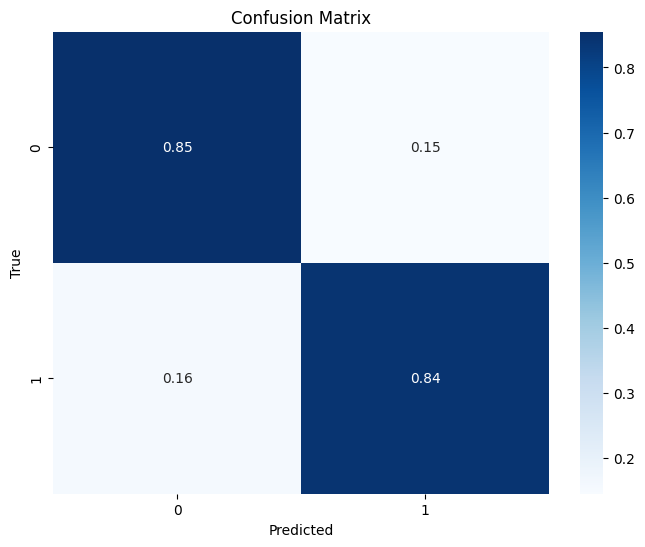

In [5]:
#y prediction for confusion matrix
y_pred = rf_full.predict(X_test)
#validation of model using normalized confusion matrix, and accuracy
cm = confusion_matrix(y_test, y_pred,normalize="true")
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

#plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues",
            xticklabels=rf_full.classes_,
            yticklabels=rf_full.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [6]:
#feature importance.
for score, name in zip(rf_full.feature_importances_, X):
    print(round(score, 3), name)

0.047 X_Minimum
0.041 X_Maximum
0.035 Y_Minimum
0.035 Y_Maximum
0.053 Pixels_Areas
0.031 X_Perimeter
0.02 Y_Perimeter
0.045 Sum_of_Luminosity
0.028 Maximum_of_Luminosity
0.051 Length_of_Conveyer
0.035 TypeOfSteel_A300
0.039 TypeOfSteel_A400
0.074 Steel_Plate_Thickness
0.034 Edges_Index
0.028 Empty_Index
0.052 Square_Index
0.035 Outside_X_Index
0.025 Edges_X_Index
0.025 Edges_Y_Index
0.002 Outside_Global_Index
0.067 LogOfAreas
0.041 Log_X_Index
0.028 Log_Y_Index
0.041 Orientation_Index
0.034 Luminosity_Index
0.022 SigmoidOfAreas
0.03 Minimum_of_Luminosity


In [7]:
#FEATURE IMPORTANCE TEST BELOW
#
#
#
#
#
#
#

In [8]:
# Reloading data set for feature importance test
steel_plates_faults = fetch_ucirepo(id=198)

X = steel_plates_faults.data.features
y = steel_plates_faults.data.targets

#change into binary
#define nondefects
nondefect_faults = ["Pastry", "Stains", "Dirtiness", "Other_Faults"]

# All fault columns in dataset
all_fault_cols = list(y.columns)

# Faults that will be labeled 1 (defects)
defect_faults = [col for col in all_fault_cols if col not in nondefect_faults]

#convert binary
y = ((y[defect_faults].sum(axis=1) > 0).astype(int))

#train random forest to test for feature importance
rf = RandomForestClassifier(n_estimators=200, random_state=42, min_samples_split=5, max_features=5, bootstrap=False)
rf.fit(X, y)
#compute feature importance
feat_imp = pd.Series(rf.feature_importances_, index=X.columns)
feat_imp = feat_imp.sort_values(ascending=False)

#K controls the amount of top features used
K = 20

#print feature importance
print("\nTop " +str(K)+ " features:")
print(feat_imp.head(K))

#saves the top features
top_features = feat_imp.head(K).index.tolist()

#reduced X to match the size for new top features
X_reduced = X[top_features]

print("\nReduced feature shape:", X_reduced.shape)

# Train-test split

X_train, X_test, y_train, y_test = train_test_split(
    X_reduced, y, test_size=0.2, random_state=42, stratify=y
)



Top 20 features:
Steel_Plate_Thickness    0.081364
LogOfAreas               0.060579
Square_Index             0.055147
Log_X_Index              0.054109
Length_of_Conveyer       0.049821
Pixels_Areas             0.049512
X_Minimum                0.047527
Orientation_Index        0.043880
Sum_of_Luminosity        0.043481
X_Maximum                0.040165
Outside_X_Index          0.038580
TypeOfSteel_A400         0.036202
TypeOfSteel_A300         0.034531
Y_Maximum                0.034280
Y_Minimum                0.032907
Luminosity_Index         0.032083
Edges_Index              0.031434
X_Perimeter              0.030234
Log_Y_Index              0.029010
Maximum_of_Luminosity    0.028802
dtype: float64

Reduced feature shape: (1941, 20)


In [9]:
#### This is Random forest as a good baseline
# Random Forest (with bagging)
rf_full = RandomForestClassifier(n_estimators=200, random_state=42, min_samples_split=5, max_features=5, bootstrap=False)
rf_full.fit(X_train, y_train)
rf_full_pred = rf_full.predict(X_test)
print("Random Forest Accuracy:" + str(round(accuracy_score(y_test, rf_full_pred),4)))

Random Forest Accuracy:0.8278



Accuracy: 0.8277634961439588

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.83      0.83       192
           1       0.83      0.83      0.83       197

    accuracy                           0.83       389
   macro avg       0.83      0.83      0.83       389
weighted avg       0.83      0.83      0.83       389



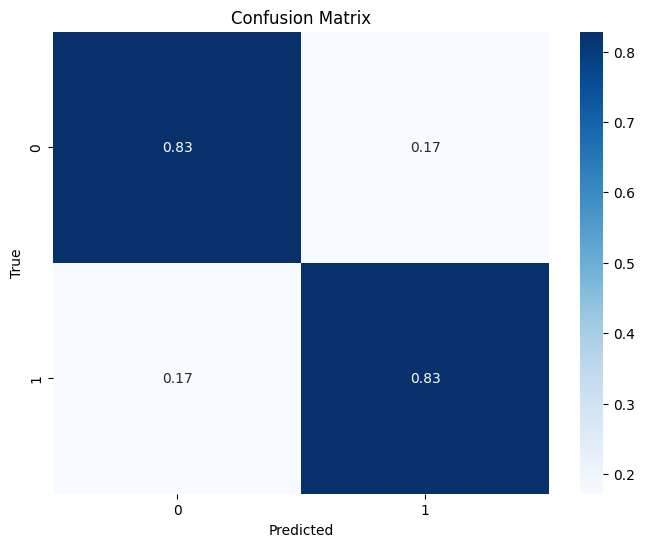

In [11]:
#saves a prediction of y for use in confusion matrix
y_pred = rf_full.predict(X_test)

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

#normalized confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize="true")

#plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues",
            xticklabels=rf_full.classes_,
            yticklabels=rf_full.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()